# **Automatidata project**

# Build a multiple linear regression model

**The goal** is to build a multiple linear regression model that predicts the fare amount of the ride and evaluate the model
<br/>
*This activity has three parts:*

**Part 1:** EDA & Checking Model Assumptions

**Part 2:** Model Building and evaluation

**Part 3:** Interpreting Model Results

# Build a multiple linear regression model

### Imports and loading

In [1]:
# Imports
# Packages for numerics + dataframes
import pandas as pd
import numpy as np

# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Packages for date conversions
from datetime import datetime
from datetime import date
from datetime import timedelta

# Packages for OLS, MLR, confusion matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics # For confusion matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error

In [2]:
df = pd.read_csv("2017_Yellow_Taxi_Trip_Data.csv")

**Note:**

Since we know that Outliers and extreme data values can significantly impact linear regression equations.

we should make a plan for addressing outliers by dropping rows, substituting extreme data with average data, and/or removing data values greater than 3 standard deviations. 

Also missing data we should make decisions on their exclusion or inclusion by substituting values with data set means, medians, and other similar methods.

Also it's important to check for things like multicollinearity between predictor variables, as well to understand their distributions, as this will help you decide what statistical inferences can be made from the model and which ones cannot.

**Note:** We know that there are no duplicates or missing values in the data from understand the data phase.

### Convert pickup & dropoff columns to datetime

**Note:** We know that the tpep_pickup_datetime, tpep_dropoff_datetime features are assigned to the wrong data type so we will have to convert them to datetime objects so we can manipulate them.

In [3]:
# Check the format of the data
df['tpep_dropoff_datetime'][0]

'03/25/2017 9:09:47 AM'

In [4]:
# Convert datetime columns to datetime
# Display data types of `tpep_pickup_datetime`, `tpep_dropoff_datetime`
print('Data type of tpep_pickup_datetime:', df['tpep_pickup_datetime'].dtype)
print('Data type of tpep_dropoff_datetime:', df['tpep_dropoff_datetime'].dtype)

# Convert `tpep_pickup_datetime` to datetime format
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'], format='%m/%d/%Y %I:%M:%S %p')

# Convert `tpep_dropoff_datetime` to datetime format
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'], format='%m/%d/%Y %I:%M:%S %p')

# Display data types of `tpep_pickup_datetime`, `tpep_dropoff_datetime`
print('Data type of tpep_pickup_datetime:', df['tpep_pickup_datetime'].dtype)
print('Data type of tpep_dropoff_datetime:', df['tpep_dropoff_datetime'].dtype)

df.head(3)

Data type of tpep_pickup_datetime: object
Data type of tpep_dropoff_datetime: object
Data type of tpep_pickup_datetime: datetime64[ns]
Data type of tpep_dropoff_datetime: datetime64[ns]


,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75


### Create duration column

In [5]:
# Create `duration` column
df['duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime'])/np.timedelta64(1,'m')

### Outliers

**Note:** We know from our previous phases that our features have alot of outliers, Keeping in mind that many of the features will not be used to fit our model, the most important columns to check for outliers are likely to be:
* `trip_distance`
* `fare_amount`
* `duration`

Let's recap how there boxplots looked like

### Box plots

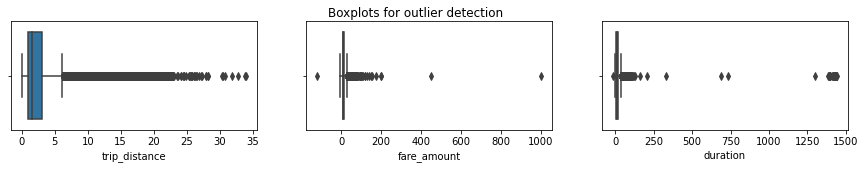

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(15, 2))
fig.suptitle('Boxplots for outlier detection')
sns.boxplot(ax=axes[0], x=df['trip_distance'])
sns.boxplot(ax=axes[1], x=df['fare_amount'])
sns.boxplot(ax=axes[2], x=df['duration'])
plt.show();

**Note:** 
1. All three variables contain outliers. Some are extreme, but others not so much.

2. It's 30 miles from the southern tip of Staten Island to the northern end of Manhattan and that's in a straight line. With this knowledge and the distribution of the values in this column, it's reasonable to leave these values alone and not alter them. However, the values for `fare_amount` and `duration` definitely seem to have problematic outliers on the higher end.

3. Probably not for the latter two, but for `trip_distance` it might be okay.

### Imputations

In [7]:
# Are trip distances of 0 bad data or very short trips rounded down?
sorted(set(df['trip_distance']))[:10]

[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]

**Note:**

The distances are captured with a high degree of precision. However, it might be possible for trips to have distances of zero if a passenger summoned a taxi and then changed their mind. Besides, are there enough zero values in the data to pose a problem?

Let's Calculate the count of rides where the `trip_distance` is zero.

In [8]:
sum(df['trip_distance']==0)

148

**Note:** 148 out of ~23,000 rides is relatively insignificant. We could impute it with a value of 0.01, but it's unlikely to have much of an effect on the model. Therefore, the `trip_distance` column will remain untouched with regard to outliers.

#### `fare_amount` outliers

In [9]:
df['fare_amount'].describe()

count    22699.000000
mean        13.026629
std         13.243791
min       -120.000000
25%          6.500000
50%          9.500000
75%         14.500000
max        999.990000
Name: fare_amount, dtype: float64

**Note:**

The range of values in the `fare_amount` column is large and the extremes don't make much sense.

* **Low values:** Negative values are problematic. Values of zero could be legitimate if the taxi logged a trip that was immediately canceled.

* **High values:** The maximum fare amount in this dataset is nearly \\$1,000, which seems very unlikely. High values for this feature can be capped based on intuition and statistics. The interquartile range (IQR) is \\$8. The standard formula of `Q3 + (1.5 * IQR)` yields \$26.50. That doesn't seem appropriate for the maximum fare cap. In this case, we'll use a factor of `6`, which results in a cap of $62.50.

Impute values less than $0 with `0`.

In [10]:
# Impute values less than $0 with 0
df.loc[df['fare_amount'] < 0, 'fare_amount'] = 0
df['fare_amount'].min()

0.0

Now impute the maximum value as `Q3 + (6 * IQR)`.

In [11]:
def outlier_imputer(column_list, iqr_factor):
    """
        Impute upper-limit values in specified columns based on their interquartile range.

        Args:
            column_list: A list of columns to iterate over
            iqr_factor: A number representing x in the formula:
                        Q3 + (x * IQR). Used to determine maximum threshold,
                        beyond which a point is considered an outlier.

        The IQR is computed for each column in column_list and values exceeding
        the upper threshold for each column are imputed with the upper threshold value.
    """
    for col in column_list:
        # Reassign minimum to zero
        df.loc[df[col] < 0, col] = 0

        # Calculate upper threshold
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        upper_threshold = q3 + (iqr_factor * iqr)
        print(col)
        print('q3:', q3)
        print('upper_threshold:', upper_threshold)

        # Reassign values > threshold to threshold
        df.loc[df[col] > upper_threshold, col] = upper_threshold
        print(df[col].describe())
        print()

In [12]:
outlier_imputer(['fare_amount'], 6)

fare_amount
q3: 14.5
upper_threshold: 62.5
count    22699.000000
mean        12.897913
std         10.541137
min          0.000000
25%          6.500000
50%          9.500000
75%         14.500000
max         62.500000
Name: fare_amount, dtype: float64



#### `duration` outliers

In [13]:
df['duration'].describe()

count    22699.000000
mean        17.013777
std         61.996482
min        -16.983333
25%          6.650000
50%         11.183333
75%         18.383333
max       1439.550000
Name: duration, dtype: float64

The `duration` column has problematic values at both the lower and upper extremities.

* **Low values:** There should be no values that represent negative time. Impute all negative durations with `0`.

* **High values:** Impute high values the same way you imputed the high-end outliers for fares: `Q3 + (6 * IQR)`.

In [14]:
# Impute a 0 for any negative values
df.loc[df['duration'] < 0, 'duration'] = 0
df['duration'].min()

0.0

In [15]:
# Impute the high outliers
outlier_imputer(['duration'], 6)

duration
q3: 18.383333333333333
upper_threshold: 88.78333333333333
count    22699.000000
mean        14.460555
std         11.947043
min          0.000000
25%          6.650000
50%         11.183333
75%         18.383333
max         88.783333
Name: duration, dtype: float64



### Feature engineering

#### Create `mean_distance` column

When deployed, the model will not know the duration of a trip until after the trip occurs, so we cannot train a model that uses this feature. However, we can use the statistics of trips we *do* know to generalize about ones we do not know.

In this step, we will create a column called `mean_distance` that captures the mean distance for each group of trips that share pickup and dropoff points.

For example, if our data were:

|Trip|Start|End|Distance|
|--: |:---:|:-:|    |
| 1  | A   | B | 1  |
| 2  | C   | D | 2  |
| 3  | A   | B |1.5 |
| 4  | D   | C | 3  |

The results should be:
```
A -> B: 1.25 miles
C -> D: 2 miles
D -> C: 3 miles
```

Notice that C -> D is not the same as D -> C. All trips that share a unique pair of start and end points get grouped and averaged.

Then, a new column `mean_distance` will be added where the value at each row is the average for all trips with those pickup and dropoff locations:

|Trip|Start|End|Distance|mean_distance|
|--: |:---:|:-:|  :--   |:--   |
| 1  | A   | B | 1      | 1.25 |
| 2  | C   | D | 2      | 2    |
| 3  | A   | B |1.5     | 1.25 |
| 4  | D   | C | 3      | 3    |


we will begin by creating a helper column called `pickup_dropoff`, which contains the unique combination of pickup and dropoff location IDs for each row.

One way to do this is to convert the pickup and dropoff location IDs to strings and join them, separated by a space. The space is to ensure that, for example, a trip with pickup/dropoff points of 12 & 151 gets encoded differently than a trip with points 121 & 51.

So, the new column would look like this:

|Trip|Start|End|pickup_dropoff|
|--: |:---:|:-:|  :--         |
| 1  | A   | B | 'A B'        |
| 2  | C   | D | 'C D'        |
| 3  | A   | B | 'A B'        |
| 4  | D   | C | 'D C'        |

#### Create `mean_duration` column

we will be the same steps but on `duration` columns

#### Create `day` and `month` columns

#### Create `rush_hour` column

we will define rush hour as:
* Any weekday (not Saturday or Sunday) AND
* Either from 06:00&ndash;10:00 or from 16:00&ndash;20:00

we will create the binary `rush_hour` column that contains a 1 if the ride was during rush hour and a 0 if it was not.

### Data leakage

When the `mean_distance` and `mean_duration` columns will be computed, the means will be calculated from the entire dataset. These same columns were then used to train a model that was used to predict on a test set. A test set is supposed to represent entirely new data that the model has not seen before, but in this case, some of its predictor variables were derived using data that *was* in the test set.

</br></br>
This is known as **<u>data leakage</u>**. Data leakage is when information from your training data contaminates the test data. 

So we will need to be careful so we will make a function that will make the feature engineering step when we split the data

In [16]:
def rush_hourizer(hour):
    """
        encodes if hour is a rush hour:
        
        Args:
            hour (int): hour
        
        Returns: 1 if it's a rush hour, else 0
    """
    if 6 <= hour['rush_hour'] < 10:
        val = 1
    elif 16 <= hour['rush_hour'] < 20:
        val = 1
    else:
        val = 0
    return val

def feature_engineer(df):
    """
        Perform feature engineering on the provided DataFrame related to taxi trip data.

        Args:
            - df (pandas DataFrame): DataFrame containing taxi trip information with columns like 'PULocationID',
              'DOLocationID', 'trip_distance', 'duration', 'tpep_pickup_datetime', etc.

        Returns:
            - df (pandas DataFrame): DataFrame with additional engineered features:
                - 'pickup_dropoff': Concatenated string of 'PULocationID' and 'DOLocationID'.
                - 'mean_distance': Mean distance for each 'pickup_dropoff' combination.
                - 'mean_duration': Mean duration for each 'pickup_dropoff' combination.
                - 'day': Day of the week extracted from 'tpep_pickup_datetime' (lowercase).
                - 'month': Month extracted from 'tpep_pickup_datetime' (abbreviated and lowercase).
                - 'rush_hour': Binary encoding (1 or 0) indicating whether the hour is a rush hour
                               based on the 'tpep_pickup_datetime' column.

        This function performs several feature engineering tasks on the provided DataFrame:
            - Concatenates pickup and dropoff locations to create a 'pickup_dropoff' column.
            - Calculates mean distance and mean duration for each pickup-dropoff combination.
            - Extracts day of the week and month from the pickup timestamp.
            - Determines rush hours based on the pickup time.

        Note:
            - The 'rush_hour' column represents whether the hour is within rush hours (6-9 and 16-19).
            - Some additional columns are expected in the input DataFrame to perform feature engineering.
            - Ensure the 'tpep_pickup_datetime' column exists and is in the appropriate datetime format.
    """
    
    # make a copy of original dataframe
    df = df.copy()
    
    # Create `pickup_dropoff` column
    df['pickup_dropoff'] = df['PULocationID'].astype(str) + ' ' + df['DOLocationID'].astype(str)
    df['pickup_dropoff'].head()
    
    # Calculate mean distance for each pickup_dropoff combinations
    grouped = df.groupby('pickup_dropoff').mean(numeric_only=True)[['trip_distance']]
    grouped.head()
    
    # Convert `grouped` to a dictionary
    grouped_dict = grouped.to_dict()['trip_distance']
    
    # Map `grouped_dict` to the `mean_distance` column
    df['mean_distance'] = df['pickup_dropoff'].map(grouped_dict)
    
    # Calculate mean duration for each pickup_dropoff combinations
    grouped = df.groupby('pickup_dropoff').mean(numeric_only=True)[['duration']]

    # Create a dictionary where keys are unique pickup_dropoffs and values are
    # mean trip duration for all trips with those pickup_dropoff combos
    grouped_dict = grouped.to_dict()['duration']

    df['mean_duration'] = df['pickup_dropoff'].map(grouped_dict)
    
    # Create 'day' col
    df['day'] = df['tpep_pickup_datetime'].dt.day_name().str.lower()

    # Create 'month' col
    df['month'] = df['tpep_pickup_datetime'].dt.strftime('%b').str.lower()
    
    # Create 'rush_hour' col
    df['rush_hour'] = df['tpep_pickup_datetime'].dt.hour

    # If day is Saturday or Sunday, impute 0 in `rush_hour` column
    df.loc[df['day'].isin(['saturday', 'sunday']), 'rush_hour'] = 0
    
    # Apply the `rush_hourizer()` function to the new column
    df.loc[(df.day != 'saturday') & (df.day != 'sunday'), 'rush_hour'] = df.apply(rush_hourizer, axis=1)
    
    return df

In [17]:
df_feat_eng = feature_engineer(df)
df_feat_eng.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,...,tolls_amount,improvement_surcharge,total_amount,duration,pickup_dropoff,mean_distance,mean_duration,day,month,rush_hour
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,...,0.0,0.3,16.56,14.066667,100 231,3.521667,22.847222,saturday,mar,0
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,...,0.0,0.3,20.80,26.500000,186 43,3.108889,24.470370,tuesday,apr,0
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,...,0.0,0.3,8.75,7.200000,262 236,0.881429,7.250000,friday,dec,1
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,...,0.0,0.3,27.69,30.250000,188 97,3.700000,30.250000,sunday,may,0
4,30841670,2,2017-04-15 23:32:20,2017-04-15 23:49:03,1,4.37,1,N,4,112,...,0.0,0.3,17.80,16.716667,4 112,4.435000,14.616667,saturday,apr,0


### Scatter plot

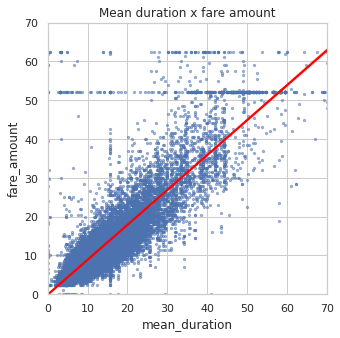

In [18]:
# Create a scatter plot of mean_duration and trip_distance, with a line of best fit
sns.set(style='whitegrid')
f = plt.figure()
f.set_figwidth(5)
f.set_figheight(5)
sns.regplot(x=df_feat_eng['mean_duration'], y=df_feat_eng['fare_amount'],
            scatter_kws={'alpha':0.5, 's':5},
            line_kws={'color':'red'})
plt.ylim(0, 70)
plt.xlim(0, 70)
plt.title('Mean duration x fare amount')
plt.show()

**Note:**

The `mean_duration` variable correlates with the target variable. But what are the horizontal lines around fare amounts of 52 dollars and 63 dollars? What are the values and how many are there?

You know what one of the lines represents. 62 dollars and 50 cents is the maximum that was imputed for outliers, so all former outliers will now have fare amounts of \$62.50. What is the other line?

Check the value of the rides in the second horizontal line in the scatter plot.

In [19]:
df_feat_eng[df_feat_eng['fare_amount'] > 50]['fare_amount'].value_counts().head()

52.0    514
62.5     84
59.0      9
50.5      9
57.5      8
Name: fare_amount, dtype: int64

**Note:** There are 514 trips whose fares were \$52.

Examine the first 30 of these trips.

In [20]:
# Set pandas to display all columns
pd.set_option('display.max_columns', None)
df[df['fare_amount']==52].head(30)

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration
11,18600059,2,2017-03-05 19:15:30,2017-03-05 19:52:18,2,18.90,2,N,236,132,1,52.0,0.0,0.5,14.58,5.54,0.3,72.92,36.800000
110,47959795,1,2017-06-03 14:24:57,2017-06-03 15:31:48,1,18.00,2,N,132,163,1,52.0,0.0,0.5,0.00,0.00,0.3,52.80,66.850000
161,95729204,2,2017-11-11 20:16:16,2017-11-11 20:17:14,1,0.23,2,N,132,132,2,52.0,0.0,0.5,0.00,0.00,0.3,52.80,0.966667
247,103404868,2,2017-12-06 23:37:08,2017-12-07 00:06:19,1,18.93,2,N,132,79,2,52.0,0.0,0.5,0.00,0.00,0.3,52.80,29.183333
379,80479432,2,2017-09-24 23:45:45,2017-09-25 00:15:14,1,17.99,2,N,132,234,1,52.0,0.0,0.5,14.64,5.76,0.3,73.20,29.483333
388,16226157,1,2017-02-28 18:30:05,2017-02-28 19:09:55,1,18.40,2,N,132,48,2,52.0,4.5,0.5,0.00,5.54,0.3,62.84,39.833333
406,55253442,2,2017-06-05 12:51:58,2017-06-05 13:07:35,1,4.73,2,N,228,88,2,52.0,0.0,0.5,0.00,5.76,0.3,58.56,15.616667
449,65900029,2,2017-08-03 22:47:14,2017-08-03 23:32:41,2,18.21,2,N,132,48,2,52.0,0.0,0.5,0.00,5.76,0.3,58.56,45.450000
468,80904240,2,2017-09-26 13:48:26,2017-09-26 14:31:17,1,17.27,2,N,186,132,2,52.0,0.0,0.5,0.00,5.76,0.3,58.56,42.850000
520,33706214,2,2017-04-23 21:34:48,2017-04-23 22:46:23,6,18.34,2,N,132,148,1,52.0,0.0,0.5,5.00,0.00,0.3,57.80,71.583333


**Note:** 

It seems that almost all of the trips in the first 30 rows where the fare amount was \$52 either begin or end at location 132, and all of them have a `RatecodeID` of 2.

There is no readily apparent reason why PULocation 132 should have so many fares of 52 dollars. They seem to occur on all different days, at different times, with both vendors, in all months. However, there are many toll amounts of $5.76 and \\$5.54. This would seem to indicate that location 132 is in an area that frequently requires tolls to get to and from. It's likely this is an airport.


The data dictionary says that `RatecodeID` of 2 indicates trips for JFK, which is John F. Kennedy International Airport. A quick Google search for "new york city taxi flat rate \$52" indicates that in 2017 (the year that this data was collected) there was indeed a flat fare for taxi trips between JFK airport (in Queens) and Manhattan.

Because `RatecodeID` is known from the data dictionary, the values for this rate code can be imputed back into the data after the model makes its predictions. This way you know that those data points will always be correct.

### Isolate modeling variables

Drop features that are redundant, irrelevant, or that will not be available in a deployed environment.

In [21]:
df_feat_eng.columns

Index(['Unnamed: 0', 'VendorID', 'tpep_pickup_datetime',
       'tpep_dropoff_datetime', 'passenger_count', 'trip_distance',
       'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID',
       'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount', 'duration',
       'pickup_dropoff', 'mean_distance', 'mean_duration', 'day', 'month',
       'rush_hour'],
      dtype='object')

In [22]:
df2 = df_feat_eng.copy()

irrelevant_cols = ['Unnamed: 0', 'tpep_dropoff_datetime', 'tpep_pickup_datetime',
               'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID',
               'payment_type', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
               'total_amount', 'tpep_dropoff_datetime', 'tpep_pickup_datetime', 'duration',
               'pickup_dropoff', 'day', 'month'
               ]
df2 = df_feat_eng.drop(irrelevant_cols, axis=1)

df2.columns

Index(['VendorID', 'passenger_count', 'fare_amount', 'mean_distance',
       'mean_duration', 'rush_hour'],
      dtype='object')

### Pair plot

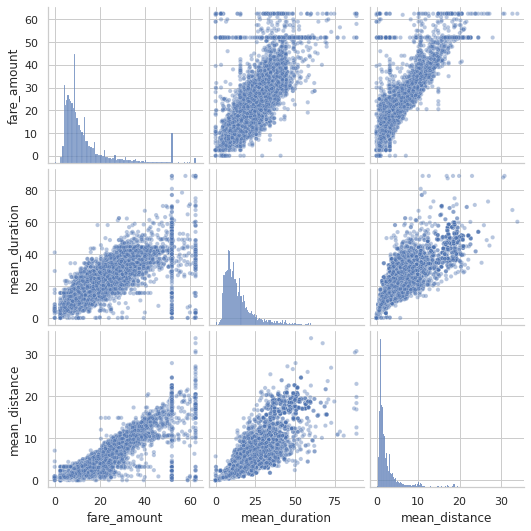

In [23]:
# Create a pairplot to visualize pairwise relationships between variables in the data
sns.pairplot(df2[['fare_amount', 'mean_duration', 'mean_distance']],
             plot_kws={'alpha':0.4, 'size':5});

These variables all show linear correlation with each other. Let's Investigate this further.

### Identify correlations

Visualize a correlation heatmap of the data.

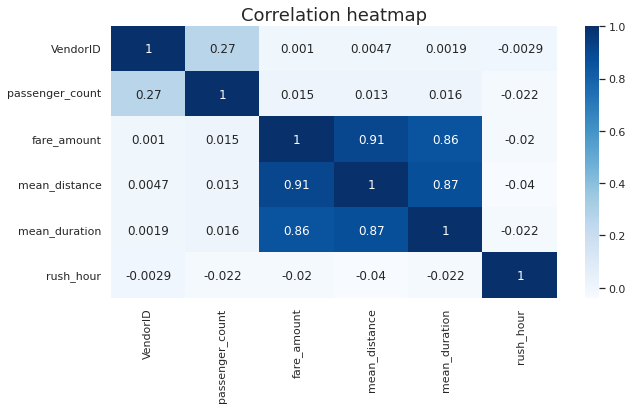

In [24]:
# Create correlation heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(df2.corr(method='pearson'), annot=True, cmap='Blues')
plt.title('Correlation heatmap', fontsize=18)
plt.show()

**Note:** `mean_duration` and `mean_distance` are both highly correlated with the target variable of `fare_amount` They're also both correlated with each other, with a Pearson correlation of 0.87.

We know that highly correlated predictor variables can be bad for linear regression models when you want to be able to draw statistical inferences about the data from the model. However, correlated predictor variables can still be used to create an accurate predictor if the prediction itself is more important than using the model as a tool to learn about your data.

This model will predict `fare_amount`, which will be used as a predictor variable in machine learning models. Therefore, we will try modeling with both variables even though they are correlated.

### Split data

In [25]:
# Remove the target column from the features
X = df.drop(columns=['fare_amount'])

# Set y variable
y = df[['fare_amount']]
    
# Display first few rows
X.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,0.0,0.5,2.76,0.0,0.3,16.56,14.066667
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,0.0,0.5,4.00,0.0,0.3,20.80,26.500000
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,0.0,0.5,1.45,0.0,0.3,8.75,7.200000
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,1,0.0,0.5,6.39,0.0,0.3,27.69,30.250000
4,30841670,2,2017-04-15 23:32:20,2017-04-15 23:49:03,1,4.37,1,N,4,112,2,0.5,0.5,0.00,0.0,0.3,17.80,16.716667


In [26]:
# Create training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration
252,31150737,2,2017-04-16 23:08:31,2017-04-16 23:24:44,1,6.02,1,N,229,168,2,0.5,0.5,0.00,0.0,0.3,20.80,16.216667
16220,33778519,2,2017-04-24 06:52:50,2017-04-24 06:55:51,1,0.66,1,N,249,114,1,0.0,0.5,1.00,0.0,0.3,6.30,3.016667
9795,43955786,1,2017-05-21 02:36:49,2017-05-21 02:42:24,2,1.40,1,N,114,231,1,0.5,0.5,1.00,0.0,0.3,8.80,5.583333
1972,2275196,1,2017-01-09 16:38:25,2017-01-09 16:43:11,1,0.50,1,N,75,236,1,1.0,0.5,0.00,0.0,0.3,6.80,4.766667
21092,52138948,1,2017-06-19 18:45:25,2017-06-19 18:54:12,1,1.00,1,N,163,142,1,1.0,0.5,1.85,0.0,0.3,11.15,8.783333


In [27]:
y_train.head()

,fare_amount
252,19.5
16220,4.5
9795,6.5
1972,5.0
21092,7.5


###  Pre-process training data

Before we train our model, we will need to perform feature engineering on the training data only to check model performance without **data leakage**.

so let's define a preprocess function

In [28]:
def preprocess(df, irrelevant_cols):
    """
        Perform preprocessing on the provided DataFrame containing taxi trip data.

        Args:
            df (pandas DataFrame): DataFrame containing features.
            irrelevant_cols (list): List of column names to be dropped as they are considered irrelevant.

        Returns:
            pandas DataFrame: Processed DataFrame after applying preprocessing steps.

        This function performs preprocessing steps on the input DataFrame:
            - Applies feature engineering using a separate function 'feature_engineer'.
            - Drops irrelevant columns specified in the 'irrelevant_cols' list.
            - Converts the 'VendorID' column to string format.
            - Obtains one-hot encoding for the 'VendorID' column.

        Note:
            - The 'feature_engineer()' function used here is assumed to perform feature engineering
              on the input DataFrame; ensure it's defined correctly.
            - Ensure the DataFrame contains necessary columns like 'fare_amount' and 'VendorID' for preprocessing.
            - The 'irrelevant_cols' list should contain names of columns considered irrelevant for the analysis.
    """
    # Perform feature engineering on data
    df = feature_engineer(df)    

    # Drop irrelevant columns
    df.drop(irrelevant_cols, axis=1, inplace=True)

    # Convert VendorID to string
    df['VendorID'] = df['VendorID'].astype(str)

    # Get One Hot encoding
    encoded_vendor = pd.get_dummies(df['VendorID'], drop_first=True)
    df['VendorID'] = encoded_vendor
    
    return df


In [29]:
X_train = preprocess(X_train, irrelevant_cols)

# Check preprocessed data
X_train.head()

,VendorID,passenger_count,mean_distance,mean_duration,rush_hour
252,1,1,6.020000,16.216667,0
16220,1,1,0.807273,7.781818,1
9795,0,2,1.184615,8.839744,0
1972,0,1,0.854444,5.762963,1
21092,0,1,0.898125,6.412500,1


### Standardize Data

In [30]:
# Standardize the X variables
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_train_scaled

array([[ 0.89286563, -0.50301524,  0.86786772,  0.17769263, -0.64893329],
       [ 0.89286563, -0.50301524, -0.58842652, -0.65425146,  1.54099045],
       [-1.11998936,  0.27331093, -0.48300724, -0.5499064 , -0.64893329],
       ...,
       [-1.11998936, -0.50301524, -0.42413838, -0.66429397, -0.64893329],
       [-1.11998936, -0.50301524, -0.58955036, -0.87055768,  1.54099045],
       [ 0.89286563,  1.82596329,  0.79926617,  1.03779826, -0.64893329]])

### Fit the model

In [31]:
# Fit Model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Evaluate model

### Train data

In [32]:
# Evaluate the model performance on the training data
r_sq = lr.score(X_train_scaled, y_train)
print('Coefficient of determination (R^2):', r_sq)
y_pred_train = lr.predict(X_train_scaled)
print('MAE:', mean_absolute_error(y_train, y_pred_train))
print('MSE:', mean_squared_error(y_train, y_pred_train))
print('RMSE:',np.sqrt(mean_squared_error(y_train, y_pred_train)))

Coefficient of determination (R^2): 0.8401439146180458
MAE: 2.157567278612778
MSE: 17.85617155170895
RMSE: 4.225656345670925


### Test data

In [33]:
# preprocess X_test data
X_test = preprocess(X_test, irrelevant_cols)

# Scale data
X_test_scaled = scaler.transform(X_test)

In [34]:
# Evaluate the model performance on the testing data
r_sq_test = lr.score(X_test_scaled, y_test)
print('Coefficient of determination (R^2):', r_sq_test)
y_pred_test = lr.predict(X_test_scaled)
print('MAE:', mean_absolute_error(y_test,y_pred_test))
print('MSE:', mean_squared_error(y_test, y_pred_test))
print('RMSE:',np.sqrt(mean_squared_error(y_test, y_pred_test)))

Coefficient of determination (R^2): 0.8854355191021244
MAE: 1.8245639318600717
MSE: 12.45849706800865
RMSE: 3.5296596249509173


**Note:** The model performance is high on both training and test sets, suggesting that there is little bias in the model and that the model is not overfit. In fact, the test scores were even better than the training scores.

For the test data, an R<sup>2</sup> of 0.885 means that 88.5% of the variance in the `fare_amount` variable is described by the model.

The mean absolute error is informative here because, for the purposes of the model, an error of two is not more than twice as bad as an error of one.

### Results

In [35]:
# Create a `results` dataframe
results = pd.DataFrame(data={'actual': y_test['fare_amount'],
                             'predicted': y_pred_test.ravel()})
results['residual'] = results['actual'] - results['predicted']
results.head()

,actual,predicted,residual
5818,14.0,14.118513,-0.118513
18134,28.0,17.576781,10.423219
4655,5.5,6.243435,-0.743435
7378,15.5,16.496928,-0.996928
13914,9.5,10.604749,-1.104749


### Visualize model results

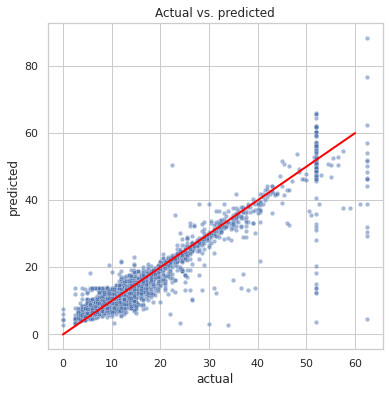

In [36]:
# Create a scatterplot to visualize `predicted` over `actual`
fig, ax = plt.subplots(figsize=(6, 6))
sns.set(style='whitegrid')
sns.scatterplot(x='actual',
                y='predicted',
                data=results,
                s=20,
                alpha=0.5,
                ax=ax
)
# Draw an x=y line to show what the results would be if the model were perfect
plt.plot([0,60], [0,60], c='red', linewidth=2)
plt.title('Actual vs. predicted');

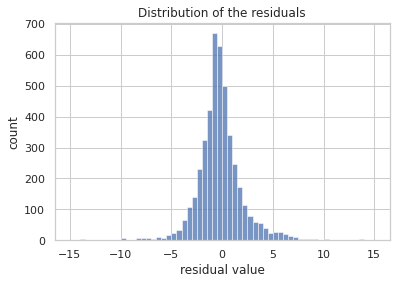

In [37]:
# Visualize the distribution of the `residuals`
sns.histplot(results['residual'], bins=np.arange(-15,15.5,0.5))
plt.title('Distribution of the residuals')
plt.xlabel('residual value')
plt.ylabel('count');

In [38]:
results['residual'].mean()

-0.030416746475428986

**Note:** The distribution of the residuals is approximately normal and has a mean of -0.030. The residuals represent the variance in the outcome variable that is not explained by the model. A normal distribution around zero is good, as it demonstrates that the model's errors are evenly distributed and unbiased.

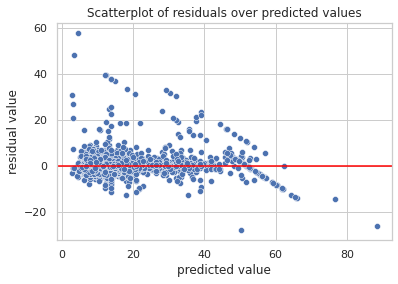

In [39]:
# Create a scatterplot of `residuals` over `predicted`
sns.scatterplot(x='predicted', y='residual', data=results)
plt.axhline(0, c='red')
plt.title('Scatterplot of residuals over predicted values')
plt.xlabel('predicted value')
plt.ylabel('residual value')
plt.show()

**Note:** The model's residuals are evenly distributed above and below zero, with the exception of the sloping lines from the upper-left corner to the lower-right corner, which you know are the imputed maximum of \\$62.50 and the flat rate of \\$52 for JFK airport trips.

###  Coefficients

In [40]:
# Get model coefficients
coefficients = pd.DataFrame(lr.coef_, columns=X_train.columns)
coefficients

,VendorID,passenger_count,mean_distance,mean_duration,rush_hour
0,-0.053188,0.024121,7.142543,2.818887,0.103446


In [41]:
# 1. Calculate SD of `mean_distance` in X_train data
print(X_train['mean_distance'].std())

# 2. Divide the model coefficient by the standard deviation
print((coefficients['mean_distance'] / X_train['mean_distance'].std()).values[0])

3.5795450399448385
1.9953774254210512


Now we can make a more intuitive interpretation: for every 3.58 miles traveled, the fare increased by a mean of \\$7.14.

Or, reduced: for every 1 mile traveled, the fare increased by a mean of \\$2.00.

## Summary

Share an executive summary with my team [link](https://github.com/yousefayman2003/Portfolio-Projects/tree/main/Data-Science/Automatidata/regression_analysis/executive_summary.pdf)

# BONUS CONTENT

More work must be done to prepare the predictions to be used as inputs into the model for our upcoming phase. This work will be broken into the following steps:

1. Get the model's predictions on the full dataset.

2. Impute the constant fare rate of \$52 for all trips with rate codes of `2`.

3. Check the model's performance on the full dataset.

4. Save the final predictions and `mean_duration` and `mean_distance` columns for downstream use.




### 1. Predict on full dataset

In [42]:
# preprocess X data
X = preprocess(X, irrelevant_cols)

# scale data
X_scaled = scaler.transform(X)

y_preds_full = lr.predict(X_scaled)

### 2. Impute ratecode 2 fare

The data dictionary says that the `RatecodeID` column captures the following information:

1 = standard rate  
2 = JFK (airport)  
3 = Newark (airport)  
4 = Nassau or Westchester  
5 = Negotiated fare  
6 = Group ride  

This means that some fares don't need to be predicted. They can simply be imputed based on their rate code. Specifically, all rate codes of `2` can be imputed with \$52, as this is a flat rate for JFK airport.

The other rate codes have some variation. They are not a fixed rate, so these fares will remain untouched.

So we will impute `52` at all predictions where `RatecodeID` is `2`.

In [43]:
# Create a new df containing just the RatecodeID col from the whole dataset
final_preds = df[['RatecodeID']].copy()

# Add a column containing all the predictions
final_preds['y_preds_full'] = y_preds_full

# Impute a prediction of 52 at all rows where RatecodeID == 2
final_preds.loc[final_preds['RatecodeID'] == 2, 'y_preds_full'] = 52

# Check that it worked
final_preds[final_preds['RatecodeID'] == 2].head()

,RatecodeID,y_preds_full
11,2,52.0
110,2,52.0
161,2,52.0
247,2,52.0
379,2,52.0


### Check performance on full dataset

In [44]:
final_preds = final_preds['y_preds_full']
print('R^2:', r2_score(y, final_preds))
print('MAE:', mean_absolute_error(y, final_preds))
print('MSE:', mean_squared_error(y, final_preds))
print('RMSE:',np.sqrt(mean_squared_error(y, final_preds)))

R^2: 0.8910547200434906
MAE: 1.9939220134734428
MSE: 12.10498413867624
RMSE: 3.4792217719881324


### Save final predictions with `mean_duration` and `mean_distance` columns

In [45]:
# Combine means columns with predictions column
nyc_preds_means = X[['mean_duration', 'mean_distance']].copy()
nyc_preds_means['predicted_fare'] = final_preds

nyc_preds_means.head()

,mean_duration,mean_distance,predicted_fare
0,22.847222,3.521667,16.416553
1,24.470370,3.108889,16.057599
2,7.250000,0.881429,7.051579
3,30.250000,3.700000,18.736983
4,14.616667,4.435000,15.857061


Save as a csv file

In [46]:
nyc_preds_means.to_csv("nyc_preds_means.csv", index=False)